In [2]:
import numpy as np
%matplotlib inline
from numpy import linalg as LA

from devito import configuration
configuration['log-level'] = 'WARNING'

### Set background velocity model and reflectivity

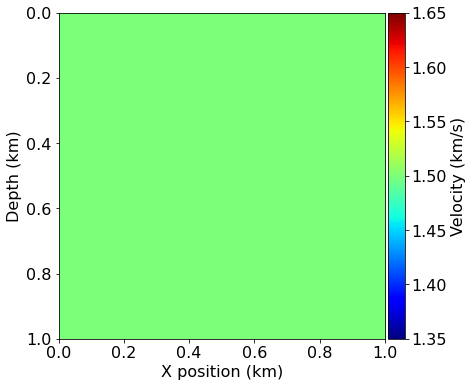

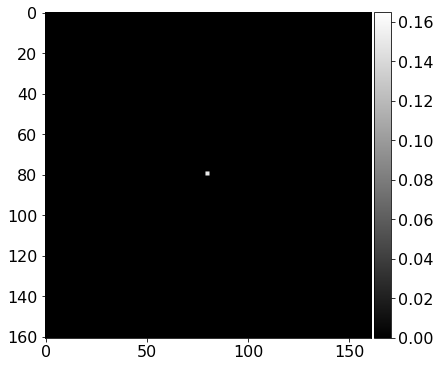

In [3]:
from examples.seismic import plot_image, plot_shotrecord
from examples.seismic import Model, plot_velocity
from scipy import ndimage

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations
nbl = 30
space_order = 4

vp = 1.5*np.ones(shape)

model0 = Model(space_order=space_order, vp=vp, origin=origin, shape=shape,
                dtype=np.float32, spacing=spacing, nbl=nbl, bcs="damp")

# Compute initial born perturbation from m - m0
dm = np.zeros(model0.grid.shape, dtype=np.float32)
dm[nbl+49:nbl+51,nbl+49:nbl+51] = 0.15

plot_velocity(model0)
plot_image(dm)

### Create geometry object

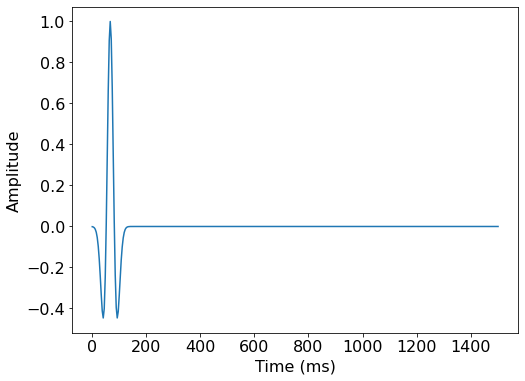

In [4]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

nshots = 3
nreceivers = 101
t0 = 0.
tn = 1500.
f0 = 0.015

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model0.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model0.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

### Visualize shots and receivers

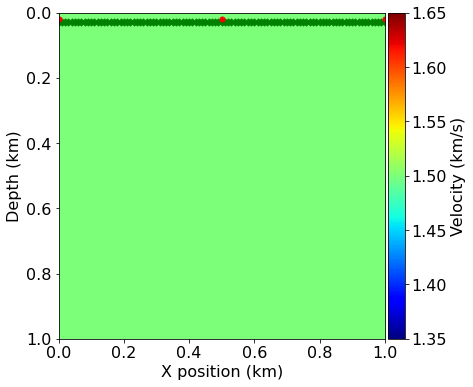

In [5]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model0.domain_size[0], num=nshots)
source_locations[:, 1] = 20.

plot_velocity(model0, source=source_locations, receiver=rec_coordinates)

### Create acoustic wave solver

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model0, geometry, space_order=space_order)

### Compute and store observed data and source illumination

In [7]:
#generates observed data 
dobs = np.empty((geometry.nt,nreceivers,nshots), dtype=np.float32)
usmo = np.empty((geometry.nt,model0.grid.shape[0],
                 model0.grid.shape[1],nshots), dtype=np.float32)
ilum = np.zeros(model0.grid.shape,dtype=np.float32)

for i in range(nshots):
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]
        
    # Generate synthetic data from true model
    true_d, _, _, _ = solver.born(dm, vp=model0.vp)
    
    # Compute smooth data and full forward wavefield u0
    _, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    #Compte source ilumination
    ilum += np.sum(u0.data * u0.data, axis=0)
    
    dobs[:,:,i] = true_d.data[:,:] 
    usmo[:,:,:,i] = u0.data[:,:,:]

### Define adjoint function. Takes the given data (dmig) 

In [8]:
from devito import Function, TimeFunction
from examples.seismic import Receiver

def adjoint(dmig):    
    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model0.grid)
       
    u = TimeFunction(name='u', grid=model0.grid, time_order=2, space_order=space_order,
                     save=geometry.nt)
    
    residual = Receiver(name='rec', grid=model0.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
            
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Compute smooth data and full forward wavefield u0
        u.data[:,:,:] = usmo[:,:,:,i]
                
        # Compute gradient from data residual and update objective function 
        residual.data[:] = dmig[:,:,i]             
        
        solver.gradient(rec=residual, u=u, vp=model0.vp, grad=grad)               
      
             
    return grad.data 

### Define Born forward modeling. It takes the current reflectivity as parameter (x)

In [9]:
from devito import Function, TimeFunction
from examples.seismic import Receiver

def forward(x):          
    
    # Create symbols to hold the reflectivity    
    rfl = Function(name="rfl", grid=model0.grid)
    rfl.data[:,:] = np.reshape(x, model0.grid.shape)  
    data = np.empty((geometry.nt,nreceivers,nshots), dtype=np.float32)
        
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
                
        # Compute smooth data and full forward wavefield u0
        smooth_d, _, _, _ = solver.born(rfl, vp=model0.vp) 
        
        data[:,:,i] = smooth_d.data[:,:]
             
    return data

In [10]:
maxiter = 20

history = np.zeros((maxiter+1, 1))
m = np.zeros(model0.grid.shape,dtype=np.float32)
dpre = forward(m)
d = dobs

residual = dpre - dobs
fobj = .5*np.linalg.norm(residual.flatten())**2
print('Objective value is %f at iteration %d' % (fobj,0)) 
history[0] = fobj

BOS = True
PBOS= False

rtm = -adjoint(dpre-d) / ilum

for i in range(maxiter):     
    
    # Step 1
    if BOS:
        print('Running BOS')
        max_delta = 1/LA.norm(ilum)
        delta = 0.4*max_delta
        print('delta = %f' % delta)
        
        m = m - delta*adjoint(dpre-d) 
        
    elif PBOS:
        print('Running PBOS')
        max_delta = 1/LA.norm(ilum*ilum)
        delta = 0.9*max_delta
        print('delta = %f' % delta)
        
        m = m - delta * adjoint(dpre-d) / ilum
    
    # determine mu
    mu = 0.1 * np.max(m)
    print('mu = %f' % mu)
    
    # shrinkage proximity
    m = np.sign(m) * np.maximum(np.abs(m) - mu*delta, 0)                             
  
    # Born forward modeling
    dpre = forward(m)
    
    # Update d
    d = d + dobs - dpre    

    # Residual value output
    residual = dpre - dobs
    fobj = .5*np.linalg.norm(residual.flatten())**2   
    history[i+1] = fobj
    print('Objective value is %f at iteration %d' % (fobj, i+1)) 
    
    if history[i+1] > history[i]:
        print('Objective value increased between iterations')
        break

Objective value is 2.041367 at iteration 0
Running BOS
delta = 0.000010
mu = 0.000007
Objective value is 2.039264 at iteration 1
Running BOS
delta = 0.000010
mu = 0.000020
Objective value is 2.035085 at iteration 2
Running BOS
delta = 0.000010
mu = 0.000041
Objective value is 2.028891 at iteration 3
Running BOS
delta = 0.000010
mu = 0.000068
Objective value is 2.020776 at iteration 4
Running BOS
delta = 0.000010
mu = 0.000102
Objective value is 2.010868 at iteration 5
Running BOS
delta = 0.000010
mu = 0.000143
Objective value is 1.999325 at iteration 6
Running BOS
delta = 0.000010
mu = 0.000191
Objective value is 1.986338 at iteration 7
Running BOS
delta = 0.000010
mu = 0.000246
Objective value is 1.972129 at iteration 8
Running BOS
delta = 0.000010
mu = 0.000308
Objective value is 1.956948 at iteration 9
Running BOS
delta = 0.000010
mu = 0.000377
Objective value is 1.941075 at iteration 10
Running BOS
delta = 0.000010
mu = 0.000452
Objective value is 1.924814 at iteration 11
Running B

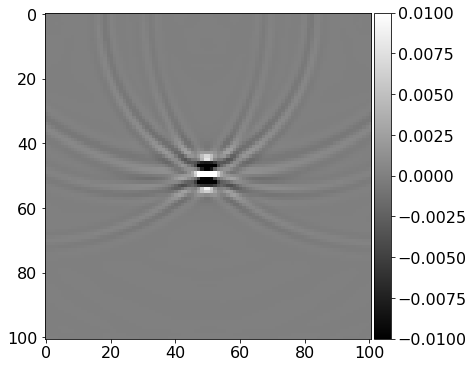

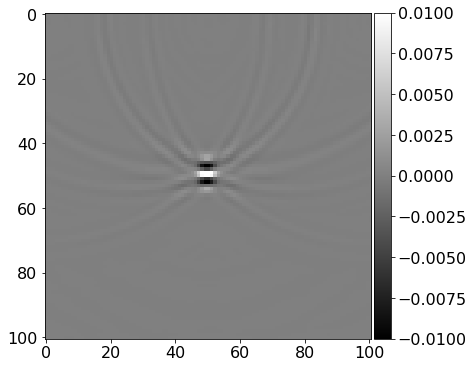

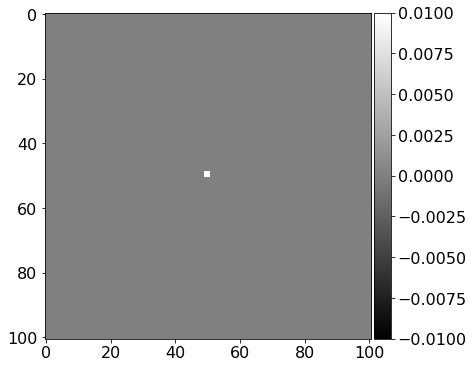

In [11]:
plot_image(rtm[nbl:shape[0]+nbl,nbl:shape[1]+nbl],vmin=-.01,vmax=.01)
plot_image(m[nbl:shape[0]+nbl,nbl:shape[1]+nbl],vmin=-.01,vmax=.01)
plot_image(dm[nbl:shape[0]+nbl,nbl:shape[1]+nbl],vmin=-.01,vmax=.01)